In [1]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import plotly.plotly as py
import plotly
import cufflinks as cf
import pprint
import json
import yaml

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords




paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
CONFIG_FILE = '../../../../../APIKeys/API.yaml'

with open(CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

PLOTLY_USERNAME = config["plotly"]["PLOTLY_USERNAME"]
PLOTLY_API_KEY = config["plotly"]["PLOTLY_API_KEY"]

plotly.tools.set_credentials_file(username = PLOTLY_USERNAME, api_key = PLOTLY_API_KEY)



In [3]:
main_data = pd.read_csv('../resources/news/business_news.csv')
main_data.head()


Published                                           Headline
0  2019-02-12T18:21:14+0000  The 2017 tax bill provides a 20 percent deduct...
1  2019-01-22T14:42:00+0000  Seeking to distinguish themselves from big riv...
2  2019-01-25T08:24:02+0000  Companies and trade groups had implored Britis...
3  2019-01-11T21:03:16+0000  Carmakers say they will idle their factories t...
4  2019-02-06T11:17:49+0000  President Trump defended his economic record, ...

In [4]:
# Grab all the titles 
article_titles = main_data['Headline']
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)


# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]


['tax',
 'bill',
 'provides',
 'percent',
 'deduction',
 'qualified',
 'business',
 'small',
 'businesses',
 'eligible']

In [5]:
main_data["Headline"][0]

'The 2017 tax bill provides a 20 percent deduction for ‘qualified business income.’ But which small businesses are eligible?'

In [6]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.\
load_word2vec_format('../resources/model/GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size


300

In [7]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape


(4804, 300)

In [8]:
df.head(10)

0         1         2         3         4         5    \
tax         0.291016  0.065430 -0.080566  0.200195  0.041504 -0.183594   
bill        0.047852  0.154297 -0.117676  0.129883 -0.147461 -0.123535   
provides   -0.130859 -0.221680 -0.132812 -0.170898  0.157227  0.054688   
percent     0.081055 -0.235352 -0.045898 -0.036377 -0.063477 -0.130859   
deduction   0.365234 -0.388672 -0.126953 -0.012573  0.239258  0.150391   
qualified  -0.217773 -0.031250  0.038086 -0.124512 -0.125000 -0.147461   
business    0.010376 -0.048584 -0.126953 -0.108887  0.030273  0.022339   
small       0.159180  0.095703 -0.125000  0.102539 -0.036133 -0.229492   
businesses  0.135742 -0.013245 -0.174805  0.093262 -0.052734 -0.004791   
eligible    0.014282 -0.088379 -0.052246  0.125977  0.032959 -0.000216   

                 6         7         8         9      ...          290  \
tax         0.195312  0.138672  0.117676  0.208984    ...    -0.328125   
bill        0.223633  0.316406 -0.064453 -0.084961    ...    -0.085938   
provides    0.069336 -0.068359  0.028320  0.065918    ...    -0.134766   
percent     0.030396 -0.255859  0.484375 -0.049561    ...    -0.192383   
deduction   0.218750 -0.019653 -0.029297  0.110840    ...    -0.382812   
qualified  -0.099121 -0.100586  0.005768 -0.164062    ...     0.119141   
business   -0.000732  0.099121  0.082031  0.018066    ...    -0.074219   
small       0.096191 -0.149414  0.015991  0.141602    ...    -0.176758   
businesses -0.145508  0.273438  0.121094 -0.006348    ...    -0.171875   
eligible    0.102051  0.110840  0.273438 -0.167969    ...     0.026001   

                 291       292       293       294       295       296  \
tax         0.131836  0.097168 -0.349609 -0.158203  0.100586 -0.051270   
bill        0.004395  0.251953 -0.269531 -0.341797  0.142578 -0.113281   
provides   -0.041016  0.058838  0.283203 -0.179688  0.249023  0.211914   
percent    -0.086426 -0.158203 -0.087891  0.106934  0.058838 -0.100098   
deduction   0.246094 -0.140625 -0.656250  0.000877 -0.255859 -0.097656   
qualified   0.079590 -0.242188  0.026367 -0.072754  0.190430  0.016968   
business    0.135742 -0.112305  0.077148  0.095703  0.093262  0.208984   
small      -0.014954 -0.027710 -0.139648  0.019043  0.125977  0.012085   
businesses  0.007996 -0.140625  0.001808  0.216797  0.099121  0.176758   
eligible    0.016968 -0.140625 -0.404297  0.457031  0.150391 -0.025024   

                 297       298       299  
tax        -0.003418  0.136719 -0.335938  
bill       -0.294922  0.251953  0.125977  
provides    0.078613  0.162109  0.196289  
percent    -0.065918  0.287109  0.037109  
deduction   0.048340  0.035156 -0.062988  
qualified  -0.158203 -0.023682 -0.091797  
business    0.183594  0.000206 -0.022095  
small       0.291016  0.024170 -0.113281  
businesses  0.170898  0.045654 -0.201172  
eligible   -0.169922  0.018311 -0.151367  

[10 rows x 300 columns]

In [9]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning:

invalid value encountered in sqrt



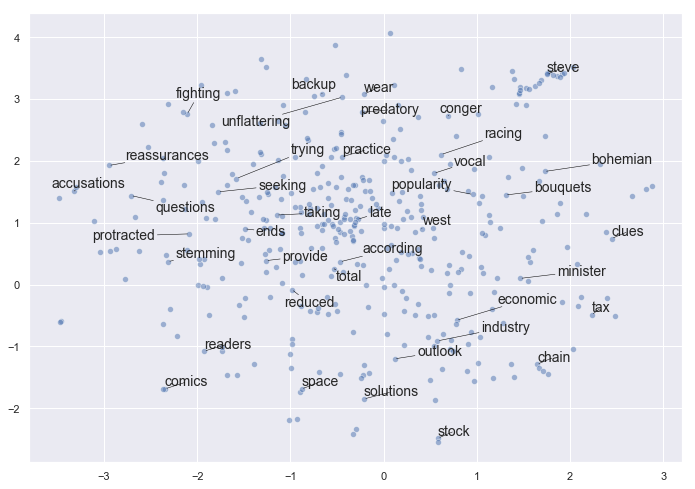

In [10]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [11]:
fig = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': df.index,
            "mode": "markers"
        }]}   

py.plot(fig)


'https://plot.ly/~nichelle/21'

In [12]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)


In [13]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array


0 docs removed
0 docs removed


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning:

invalid value encountered in sqrt



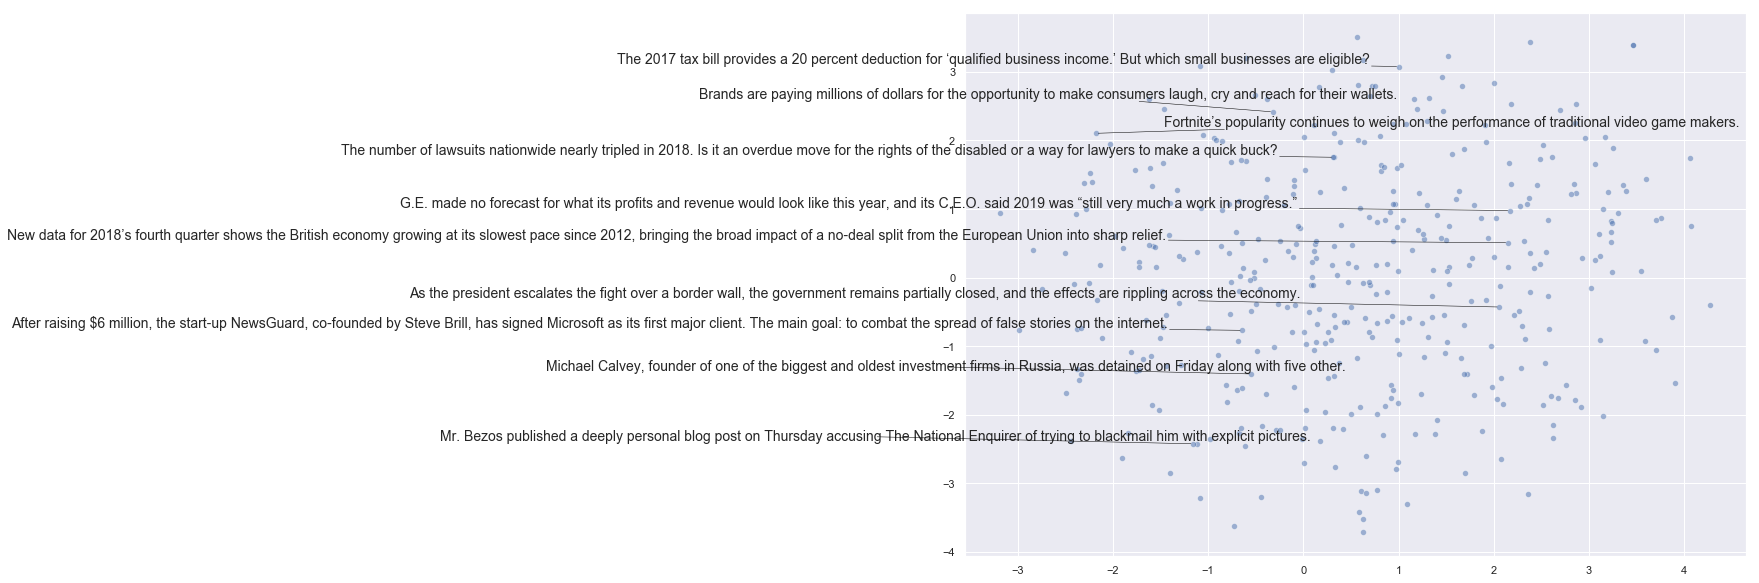

In [14]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [15]:
print(titles_to_plot)
type(texts[0])

[0, 40, 80, 120, 160, 200, 240, 280, 320, 360]


matplotlib.text.Text

In [16]:
fig2 = {
    'data': [
  		{
  			'x': tsne_df[:, 0], 
        	'y': tsne_df[:, 1], 
        	'text': titles_list,
            "mode": "markers"
        }]}   

py.plot(fig2)

'https://plot.ly/~nichelle/23'